# Causality of Economic Uncertainty on Bitcoin Prices
_School of Information Technology & School of Business_ <br>
_Monash University Malaysia_<br>
(c) Copyright 2020, Ian Tan & Poon Wai Ching

For Cross Mapping<br>
https://github.com/nickc1/skccm

Good tutorial<br>
https://notebook.community/NickC1/skCCM/scripts/skCCM_examples

Original article<br>
https://pubmed.ncbi.nlm.nih.gov/22997134/

Good explanation<br>
https://arxiv.org/abs/1407.5696

Steps

- Read dataset (BTC, Global EPU from (https://www.policyuncertainty.com/index.html)
- Wrangle and merge dataset
- Conduct Convergent Cross Mapping (sklearn)

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Read datasets

In [77]:
globalDf = pd.read_csv("data/Global_Policy_Uncertainty_Data-Since1997.csv", encoding="latin-1")
btcDf = pd.read_csv("data/BTC-Monthly-Since2014.csv")

## Wrangle Global EPU dataset

In [78]:
globalDf.head()

,Year,Month,GEPU_current,GEPU_ppp
0,1997,1.0,74.250916,76.827372
1,1997,2.0,77.455858,79.145625
2,1997,3.0,66.761655,64.889262
3,1997,4.0,71.868261,73.164048
4,1997,5.0,69.901362,70.204210


In [79]:
globalDf.dtypes

Year             object
Month           float64
GEPU_current    float64
GEPU_ppp        float64
dtype: object

In [80]:
globalDf = globalDf.dropna()

In [81]:
globalDf.tail()

,Year,Month,GEPU_current,GEPU_ppp
280,2020,5.0,412.826586,423.968339
281,2020,6.0,313.741755,333.653920
282,2020,7.0,337.384424,340.895162
283,2020,8.0,285.883907,306.856490
284,2020,9.0,286.915497,298.280919


In [82]:
globalDf['Year'] = globalDf['Year'].astype('int')

In [83]:
globalDf.drop(globalDf[globalDf['Year'] < 2014].index, inplace=True)

In [84]:
globalDf['Year'] = globalDf['Year'].astype('int')

In [85]:
globalDf['Month'] = globalDf['Month'].astype('int')

In [86]:
globalDf.head()

,Year,Month,GEPU_current,GEPU_ppp
204,2014,1,107.324807,108.767217
205,2014,2,94.643427,92.150604
206,2014,3,109.436900,107.244238
207,2014,4,97.775491,101.434120
208,2014,5,100.257487,102.025873


In [87]:
len(globalDf)

81

## Wrangle BTC dataset

In [88]:
btcDf.head()

,Date (based on 1st of Month),Open,High,Low,Close,Volume
0,Sep-2014,465.864014,468.174011,372.239990,386.944000,4.108810e+08
1,Oct-2014,387.427002,411.697998,289.295990,338.321014,9.029944e+08
2,Nov-2014,338.649994,457.092987,320.626007,378.046997,6.597334e+08
3,Dec-2014,378.248993,384.037994,304.231995,320.192993,5.531023e+08
4,Jan-2015,320.434998,320.434998,171.509995,217.464005,1.098812e+09


In [89]:
btcDf.dtypes

Date (based on 1st of Month)     object
Open                            float64
High                            float64
Low                             float64
Close                           float64
Volume                          float64
dtype: object

In [90]:
btcDf['Year'] = pd.DatetimeIndex(btcDf['Date (based on 1st of Month)']).year
btcDf['Month'] = pd.DatetimeIndex(btcDf['Date (based on 1st of Month)']).month
btcDf.head()

,Date (based on 1st of Month),Open,High,Low,Close,Volume,Year,Month
0,Sep-2014,465.864014,468.174011,372.239990,386.944000,4.108810e+08,2014,9
1,Oct-2014,387.427002,411.697998,289.295990,338.321014,9.029944e+08,2014,10
2,Nov-2014,338.649994,457.092987,320.626007,378.046997,6.597334e+08,2014,11
3,Dec-2014,378.248993,384.037994,304.231995,320.192993,5.531023e+08,2014,12
4,Jan-2015,320.434998,320.434998,171.509995,217.464005,1.098812e+09,2015,1


In [91]:
# Estatics only, I just wanted the year and month in front
cols = btcDf.columns.tolist()
cols = cols[-1:] + cols[:-1]; cols = cols[-1:] + cols[:-1]
btcDf = btcDf[cols]
# Delete the not needed column
del btcDf['Date (based on 1st of Month)']

In [92]:
btcDf.reset_index()
btcDf.head()

,Year,Month,Open,High,Low,Close,Volume
0,2014,9,465.864014,468.174011,372.239990,386.944000,4.108810e+08
1,2014,10,387.427002,411.697998,289.295990,338.321014,9.029944e+08
2,2014,11,338.649994,457.092987,320.626007,378.046997,6.597334e+08
3,2014,12,378.248993,384.037994,304.231995,320.192993,5.531023e+08
4,2015,1,320.434998,320.434998,171.509995,217.464005,1.098812e+09


In [93]:
btcDf.tail()

,Year,Month,Open,High,Low,Close,Volume
67,2020,4,6437.319336,9440.650391,6202.373535,8658.553711,1.156130e+12
68,2020,5,8672.782227,9996.743164,8374.323242,9461.058594,1.286370e+12
69,2020,6,9463.605469,10199.565430,8975.525391,9137.993164,6.509130e+11
70,2020,7,9145.985352,11415.864260,8977.015625,11323.466800,5.458130e+11
71,2020,8,11322.570310,12034.144530,11012.415040,11675.739260,1.797630e+11


In [94]:
len(btcDf)

72

## Merge Data

As the BTC dataset only starts from September 2014 and the China and US dataset is only up to July 2020, we will need to filter them before combining all of them together in one dataframe.


In [95]:
globalDf = globalDf[ ~((globalDf['Year'] == 2020) & (globalDf['Month'] > 7)) ]
globalDf = globalDf[ ~((globalDf['Year'] == 2014) & (globalDf['Month'] < 9)) ]

In [96]:
btcDf = btcDf[ ~((btcDf['Year'] == 2020) & (btcDf['Month'] > 7)) ]

In [97]:
if (len(btcDf) == len(globalDf)):
    print("Data frames ready to merge")

Data frames ready to merge


In [98]:
allDf = btcDf.merge(globalDf)

In [99]:
allDf.head()

,Year,Month,Open,High,Low,Close,Volume,GEPU_current,GEPU_ppp
0,2014,9,465.864014,468.174011,372.239990,386.944000,4.108810e+08,119.004523,123.848461
1,2014,10,387.427002,411.697998,289.295990,338.321014,9.029944e+08,115.001499,117.841802
2,2014,11,338.649994,457.092987,320.626007,378.046997,6.597334e+08,109.575411,115.329683
3,2014,12,378.248993,384.037994,304.231995,320.192993,5.531023e+08,107.930762,109.408125
4,2015,1,320.434998,320.434998,171.509995,217.464005,1.098812e+09,131.733360,138.663842


In [100]:
# Let's save this for a bit
allDf.to_csv('data/allData.csv')

The dataset has no NaN values, if there are, best practise is to pad it

We use only the BTC closing price.

In [101]:
gDf = allDf.loc[:,['Close', 'GEPU_current']]
gDf.columns = ['BTC','GlobalEPU']
gDf.head()

,BTC,GlobalEPU
0,386.944000,119.004523
1,338.321014,115.001499
2,378.046997,109.575411
3,320.192993,107.930762
4,217.464005,131.733360


Let's visualise the data.

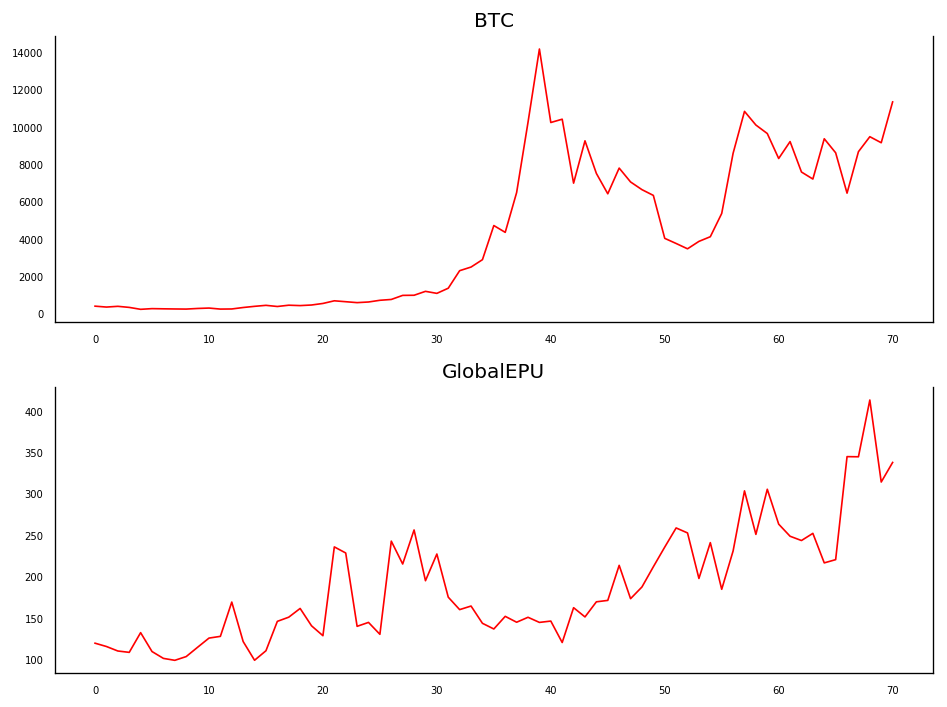

In [102]:
dataset = gDf.loc[:,['BTC','GlobalEPU']]
fig, axes = plt.subplots(nrows=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

# Convergent Cross Mapping

Convergent Cross Mapping (skccm) can be used as a way to detect causality between time series.

In [103]:
import skccm as ccm
import seaborn as sns # For some of the visualisation

Based on the 5 steps algorithm provided by McCraken and Weigel, the first 2 steps is done using the [skccm embed function](https://skccm.readthedocs.io/en/latest/embed.html).  Note that the library does not yet implement the nearest neighbour and we can later try to optimize this by using the nearest neighbour function from sckit-learn.

In [104]:
lag = 1
embed = 2
e1 = ccm.Embed(gDf['BTC'])
e2 = ccm.Embed(gDf['GlobalEPU'])
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

Let's visualise the embedded information

Text(0, 0.5, 'X2(t-1)')

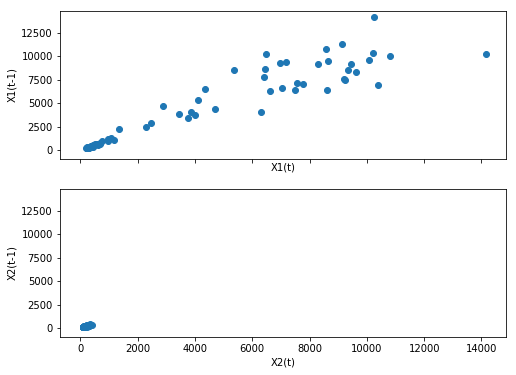

In [105]:
fig,ax = plt.subplots(nrows=2,sharey=True,sharex=True,figsize=(8,6)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')

Steps 3 - 5 as stated in the McCraken and Weigel, is basically using different weights and trying to determine the accuracy by varying the library lenght (the time series window).  We forecast as a function of the library length.


In [106]:
CCM = ccm.CCM()
from skccm.utilities import train_test_split
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.8)

In [107]:
len_tr = len(x1tr)
lib_lens = np.linspace(10, len_tr/2, dtype='int')
lib_lens

array([10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15,
       16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 22,
       22, 22, 23, 23, 23, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 28])

In [108]:
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

We find the output score of the CCM.

In [109]:
sc1,sc2 = CCM.score()

Let's visualise it.

Text(0, 0.5, 'Forecast Skill')

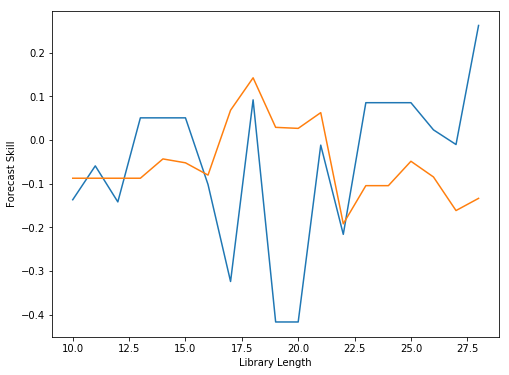

In [110]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(lib_lens,sc1,label='X1 "CCM cause" X2')
ax.plot(lib_lens,sc2, label='X2 "CCM cause" X1')
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')

Generally, neither BTC nor economic policy uncertainty have any causation on the other.

# END

## Stationary Data (after checking with other experts, not needed)

I am not sure if the input data needs to be stationary but from my understanding of how CCM works, it doesn't have to be.
Anyway, let us experiment with stationary time series data.

In [111]:
dataset['GlobalEPU'] = np.diff(dataset['GlobalEPU'], prepend=dataset['GlobalEPU'][0])
dataset['BTC'] = np.diff(dataset['BTC'], prepend=dataset['BTC'][0])

Text(0.5, 0, 'Time')

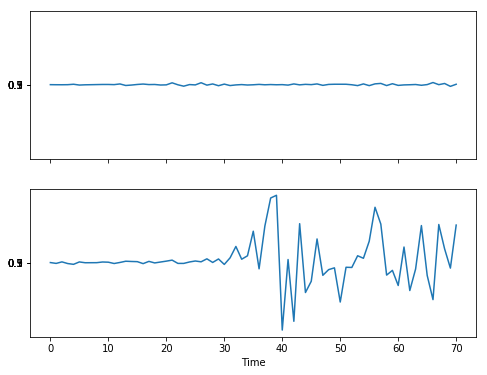

In [112]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True,figsize=(8,6))

ax[0].plot(dataset['GlobalEPU'])
ax[1].plot(dataset['BTC'])
ax[0].set_yticks([.1,.3,.5,.7,.9])
ax[1].set_xlabel('Time')

### Calculate the mutual information of the various indices

In [113]:
e1 = ccm.Embed(dataset['GlobalEPU'])
e2 = ccm.Embed(dataset['BTC'])

In [114]:
mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

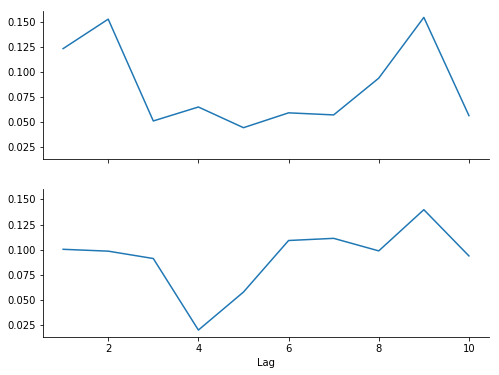

In [115]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True,figsize=(8,6))
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

### Embedding the time series

In [116]:
lag = 1
embed = 2
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

Text(0, 0.5, 'X2(t-1)')

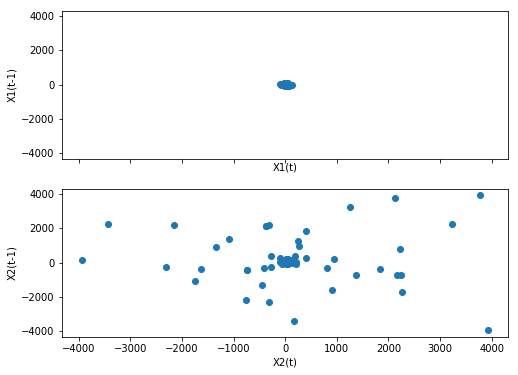

In [117]:
fig,ax = plt.subplots(nrows=2,sharey=True,sharex=True,figsize=(8,6)) 

ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])

ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')

Text(0, 0.5, 'Forecast Skill')

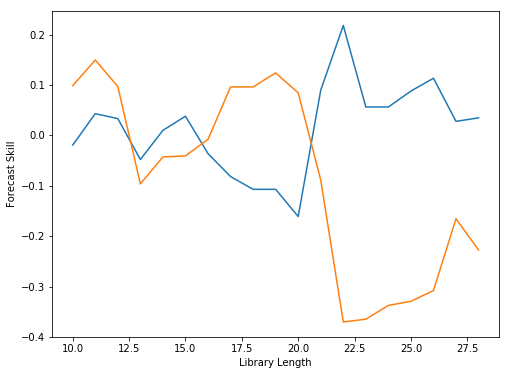

In [118]:
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.8)
len_tr = len(x1tr)
lib_lens = np.linspace(10, len_tr/2, dtype='int')
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
sc1,sc2 = CCM.score()
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(lib_lens,sc1,label='X1 "CCM cause" X2')
ax.plot(lib_lens,sc2, label='X2 "CCM cause" X1')
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')